# Evolutionary Strategies to evolve Neural Networks

In [3]:
# Import the necessary modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import pchip
from random import random, randint
import tensorflow as tf
from operator import add
from functools import reduce

In [29]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [46]:
# Create an individual here // n_layers + space for accuracy
def individual(n_layers, minimum, maximum, alpha_max, alpha_min):
	return [ randint(minimum, maximum) for n in range(n_layers)]+[randint(alpha_min, alpha_max), 0]

In [44]:
# Create the population here
def population(n_nets, n_layers, minimum, maximum, alpha_max, alpha_min):
	return [ individual(n_layers, minimum, maximum, alpha_max, alpha_min) for n in range(n_nets) ]

In [48]:
# Measure the fitness of an entire population. Lower is better.
def evaluate(population):
	total = reduce(add, ([n[-1] for n in population]), 0)
	return total / float(len(population))

In [86]:
# Evolve individuals and create the next generation. Select the 20% best. Not the best approach
def evolve(population, minimum, maximum, n_nets, n_layers, retain, random_aditional, mutation):
    tupled = [ neural(net) for net in population ]
    tupled = [ net for net in sorted(tupled, key=lambda x: x[-1], reverse=True)]
    retain_length = int(retain*n_nets)
    
    # Print the best Net of the generation
    print("Best of that Generation: ",tupled[0])
    # Continue
    
    parents = tupled[:retain_length]
    # Select other individuals randomly to maintain genetic diversity. Could be avoided with a better approach.
    for net in tupled[retain_length:]:
        if random_aditional > random():
            parents.append(net)
    # Mutate some individuals to maintain genetic diversity
    for net in parents:
        for i in range(n_layers):
            if mutation > random():
                net[i] = randint(minimum, maximum)
    # Crossover of parents to generate children
    parents_length = len(parents)
    children_maxlength = n_nets - parents_length
    children = []
    while len(children) < children_maxlength:
        male = randint(0, parents_length-1)
        female = randint(0, parents_length-1)
        if male != female:
            male = parents[male]
            female = parents[female]
            cross_point = randint(0, n_layers+2)
            child = male[:cross_point]+female[cross_point:] 			# Combine male and female
            children.append(child)
    parents.extend(children)											# Extend parents list by appending children list
    return parents 												# Return the next Generation of individuals


In [88]:
# Get the accuracy for a given neural net
def neural(net):
    
    batch_size = 100
    K = net[0]
    L = net[1]
    alpha = net[2]/100000

    W1 = tf.Variable(tf.truncated_normal([28*28, K], stddev = 0.1))
    B1 = tf.Variable(tf.zeros([K]))
    W2 = tf.Variable(tf.truncated_normal([K, L], stddev = 0.1))
    B2 = tf.Variable(tf.zeros([L]))
    W3 = tf.Variable(tf.truncated_normal([L, 10], stddev = 0.1))
    B3 = tf.Variable(tf.zeros([10]))

    X = tf.placeholder(tf.float32, [None, 28 * 28]) 	# One layer because 28*28 gray-scaled images, the None will become the batch size
    X = tf.reshape(X, [-1, 28*28])

    # Defining the model - changing relu by my_function
    Y1 = tf.nn.relu(tf.matmul(X, W1) + B1)
    Y2 = tf.nn.relu(tf.matmul(Y1, W2) + B2)
    Y3 = tf.nn.softmax(tf.matmul(Y2, W3) + B3)

    init = tf.global_variables_initializer()

    # Defining the placeholder for correct answers
    Y_ = tf.placeholder(tf.float32, [None, 10]) 		# "One-hot" encoded vector (00001000000)

    # SUCCESS metrics
    # Loss function to determine how bad is the model
    cross_entropy = -tf.reduce_sum(Y_ * tf.log(Y3)) 	# If Y is 1, log(Y) = 0, if Y is 0, log(Y) = -infinite
    # % of correct answers found in batch
    is_correct = tf.equal(tf.argmax(Y3, 1), tf.argmax(Y_, 1))	# "One-hot" decoding here
    accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

    # Training step
    optimizer = tf.train.GradientDescentOptimizer(alpha)
    train_step = optimizer.minimize(cross_entropy)

    # RUN the fuckin' code here
    sess = tf.Session() 								# Code in tf is not computed until RUN
    sess.run(init)
    # Training loop
    for i in range(125):
        # Load batch of images and correct answers
        batch_X, batch_Y = mnist.train.next_batch(batch_size)	# Train on mini_batches of 100 images
        train_data = {X: batch_X, Y_: batch_Y}
        # Train
        sess.run(train_step, feed_dict = train_data)
        # {X: batch_X, Y_: batch_Y}
        
    # Succes on training data
    a_tr, c_tr = sess.run([accuracy, cross_entropy], feed_dict = train_data)
    # Success on test data?
    test_data = {X: mnist.test.images, Y_: mnist.test.labels}
    a_test, c_test = sess.run([accuracy, cross_entropy], feed_dict = test_data)
    print("Net (1st:"+str(K)+", 2nd:"+str(L)+", Alpha:"+str(alpha)+"): acc_train:", a_tr, "|| acc_test:", a_test)
    
    sess.close() # Closing the session
    
    return [K, L, alpha*1000, a_test*100]

In [41]:
for i in range(5):
    print(neural([randint(1,100), randint(1,100), randint(1,300), 0]))

Net (1st:56, 2nd:81): acc_train: 0.89 || acc_test: 0.9118
[56, 81, 0.00085, 91.180002689361572]
Net (1st:2, 2nd:45): acc_train: 0.66 || acc_test: 0.5794
[2, 45, 0.00114, 57.940000295639038]
Net (1st:50, 2nd:60): acc_train: 0.96 || acc_test: 0.9282
[50, 60, 0.0017, 92.820000648498535]
Net (1st:22, 2nd:86): acc_train: 0.9 || acc_test: 0.9035
[22, 86, 0.00111, 90.35000205039978]
Net (1st:9, 2nd:93): acc_train: 0.94 || acc_test: 0.8979
[9, 93, 0.0018, 89.789998531341553]


In [75]:
# Declare parameters
N_MAX_NEURONS = 100
N_MIN_NEURONS = 1
ALPHA_MAX = 300
ALPHA_MIN = 1
N_LAYERS = 2
N_NETS = 10
N_ITER = 5
RETAIN = 0.2
MUTATION = RANDOM_ADD = 0.1

In [80]:
# Plot the Fitness of each generation. Lower is better
def plot_graph(eval_history):
    x = [g for g in range(len(eval_history))]
    # Data to be interpolated.
    y = eval_history
    # Define plots.
    plt.plot(x, y, 'r.')
    plt.grid(True)
    plt.title("Graph visualization")
    plt.xlabel("Generations")
    plt.ylabel("Average Accuracy after 10o learning episodes")
    # Plot it all
    plt.show()

Net (1st:51, 2nd:1, Alpha:0.00105): acc_train: 0.24 || acc_test: 0.2077
Net (1st:95, 2nd:81, Alpha:0.00105): acc_train: 0.92 || acc_test: 0.8731
Net (1st:32, 2nd:3, Alpha:0.00225): acc_train: 0.42 || acc_test: 0.4271
Net (1st:55, 2nd:61, Alpha:0.003): acc_train: 0.94 || acc_test: 0.8695
Net (1st:18, 2nd:82, Alpha:0.00085): acc_train: 0.71 || acc_test: 0.766
Net (1st:36, 2nd:72, Alpha:0.00223): acc_train: 0.91 || acc_test: 0.8769
Net (1st:90, 2nd:18, Alpha:0.00198): acc_train: 0.84 || acc_test: 0.7779
Net (1st:28, 2nd:51, Alpha:0.00041): acc_train: 0.53 || acc_test: 0.5143
Net (1st:35, 2nd:31, Alpha:0.00106): acc_train: 0.82 || acc_test: 0.7131
Net (1st:34, 2nd:24, Alpha:0.00018): acc_train: 0.2 || acc_test: 0.2643
Best of that Generation:  [36, 72, 2.2300000000000004, 87.690001726150513]
------ GEN 1 ------
Net (1st:36, 2nd:72, Alpha:2.2300000000000003e-05): acc_train: 0.08 || acc_test: 0.1548
Net (1st:95, 2nd:81, Alpha:1.0500000000000001e-05): acc_train: 0.15 || acc_test: 0.1651
Net (

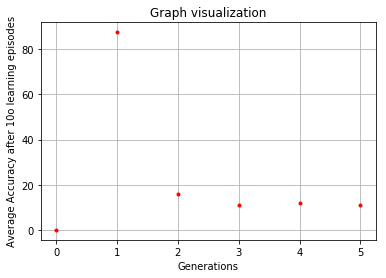

In [89]:
pop = population(N_NETS, N_LAYERS, N_MIN_NEURONS, N_MAX_NEURONS, ALPHA_MAX, ALPHA_MIN)
evaluation = evaluate(pop)
eval_history = [evaluation] # Record w/ the average acc of all generations

for i in range(N_ITER):
    pop = evolve(pop, N_MIN_NEURONS, N_MAX_NEURONS, N_NETS, N_LAYERS, RETAIN, RANDOM_ADD, MUTATION)
    print("------ GEN "+str(i+1)+" ------")
    eval_history.append(evaluate(pop))

print("------------------------------")
print("------------------------------")
print(eval_history)
plot_graph(eval_history)